In [ ]:
pip install tensorflow


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload the data to ensure we have all original columns again
df = pd.read_csv("energydata_with_cost.csv")

# Recalculate energy_per_hour
df["energy_per_hour"] = df["chargedEnergyKwh"] / (df["chargingDurationMs"] / 3600000.0)

# Convert timestamp and extract hour
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df["hour_of_day"] = df["chargingStartTime"].dt.hour

# 1. Describe energy_per_hour
energy_stats = df["energy_per_hour"].describe()

# 2. Number of charging sessions per hour of day
sessions_per_hour = df["hour_of_day"].value_counts().sort_index()

# 3. Total charged energy per hour of day
total_energy_per_hour = df.groupby("hour_of_day")["chargedEnergyKwh"].sum()

# 4. Median energy per hour of day
median_energy_per_hour = df.groupby("hour_of_day")["energy_per_hour"].median()


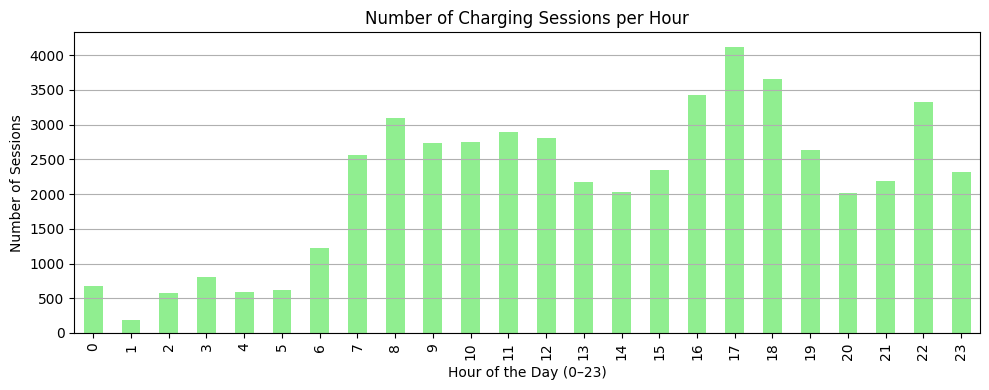

In [ ]:
# Plot 1: Number of sessions per hour
plt.figure(figsize=(10, 4))
sessions_per_hour.plot(kind="bar", color="lightgreen")
plt.title("Number of Charging Sessions per Hour")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Number of Sessions")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#**This plot shows how many charging sessions begin during each hour of the day.**

###**Key Observations:**
- Most charging sessions happen between 6:00 and 23:00.

- There is a clear peak around 17:00, indicating the busiest time for charging activity.

- Nighttime (0:00–5:00) shows very low activity, especially around 1:00.

- Charging sessions begin to rise sharply after 6:00, peaking in the afternoon, then dropping again at night.

### **What does this mean?**
- Buses are mostly in service during the day and begin charging after returning, typically in the late afternoon.

- The 17:00 and 22:00 peaks reflects the end of bus shifts and the beginning of charging at depots.

- Infrastructure planning should focus on the afternoon peak hours, when multiple buses require charging simultaneously.

- Low activity at night may suggest limited overnight charging, or use of slower charging rates.



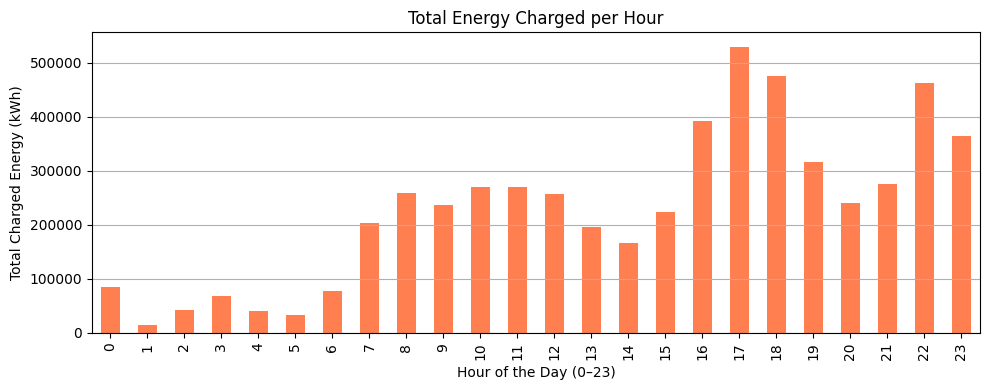

In [ ]:
# Plot 2: Total energy charged per hour
plt.figure(figsize=(10, 4))
total_energy_per_hour.plot(kind="bar", color="coral")
plt.title("Total Energy Charged per Hour")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Total Charged Energy (kWh)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#**This bar chart shows the total energy charged (in kWh) for all sessions that started during each hour of the day.**

### **Key Observations:**
- Energy charged is lowest between 1:00 and 5:00, when few sessions occur.

- There is a gradual increase starting at 6:00, peaking at 17:00.

- High charging volumes are seen from 16:00 to 18:00, and again around 22:00–23:00.

### **What does this mean?**
- The total energy demand closely follows session frequency: more buses charging = more energy delivered.

- Peak demand occurs late afternoon, which is critical for infrastructure planning — chargers and power supply must be scaled for this.

The sharp increase in total energy charged between 16:00 - 18:00 and 22.00 - 23.00, most likely reflects the moment when buses return from their daily routes and begin charging at the depot.



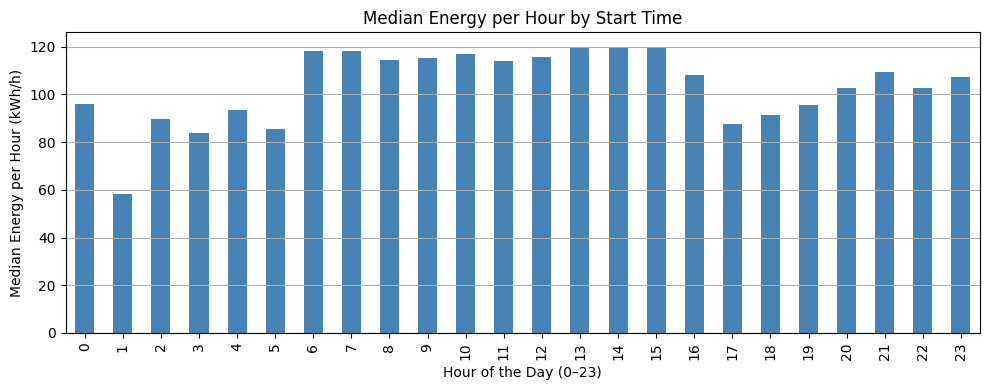

In [ ]:
# Plot 3: Median energy per hour
plt.figure(figsize=(10, 4))
median_energy_per_hour.plot(kind="bar", color="steelblue")
plt.title("Median Energy per Hour by Start Time")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Median Energy per Hour (kWh/h)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#**This plot shows the median charging power (kWh/h) based on the hour of the day when a charging session starts.**

### **Key Observations:**
From 6:00 to 15:00, charging power is highest (around 115–120 kWh/h).
- Buses charge fastest during this period.

After 16:00, the charging power drops noticeably.
- This means buses charge slower in the evening.

Charging power is lowest between 1:00 and 2:00, likely due to slower overnight sessions.

### **What does this mean?**
During the day, buses likely return with low battery and charge at full power.

In the evening, they may:

- charge for shorter periods,

- have a higher state of charge (SoC) when they arrive,

- or share power with more buses charging at once.




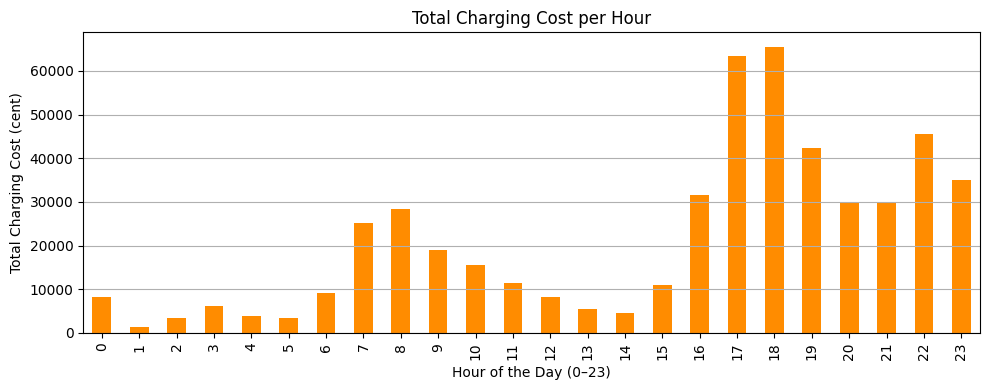

In [ ]:
# Plot 4

import pandas as pd
import matplotlib.pyplot as plt

# Laad data
df = pd.read_csv("energydata_with_cost.csv")

# Zorg dat chargingStartTime correct is
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df["hour_of_day"] = df["chargingStartTime"].dt.hour

# Groepeer per uur en sommeer de laadkosten (in centen!)
cost_per_hour_cent = df.groupby("hour_of_day")["estimatedCostEUR"].sum()

# Plot
plt.figure(figsize=(10, 4))
cost_per_hour_cent.plot(kind="bar", color="darkorange")
plt.title("Total Charging Cost per Hour")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Total Charging Cost (cent)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


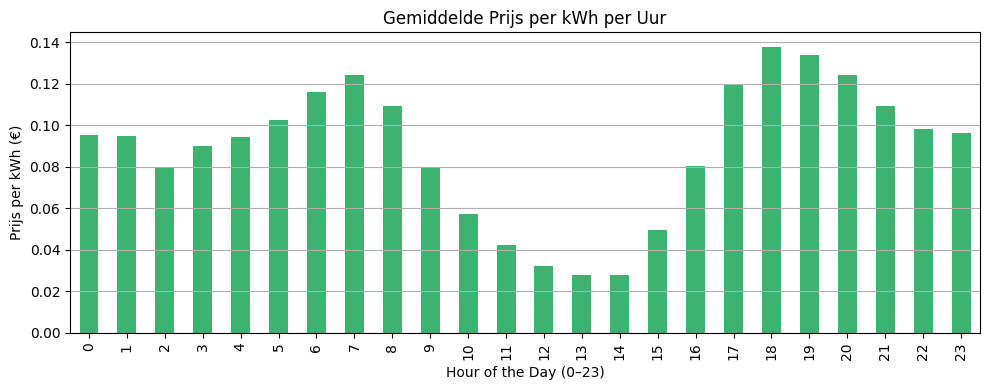

In [ ]:
# Plot 5

import pandas as pd
import matplotlib.pyplot as plt

# Laad de data
df = pd.read_csv("energydata_with_cost.csv")
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df["hour_of_day"] = df["chargingStartTime"].dt.hour

# Bereken prijs per kWh per uur
cost_per_hour = df.groupby("hour_of_day")["estimatedCostEUR"].sum()
energy_per_hour = df.groupby("hour_of_day")["chargedEnergyKwh"].sum()

# Vermijd deling door 0
price_per_kwh = (cost_per_hour / energy_per_hour).replace([float('inf'), -float('inf')], 0).fillna(0)

# Plot
plt.figure(figsize=(10, 4))
price_per_kwh.plot(kind="bar", color="mediumseagreen")
plt.title("Gemiddelde Prijs per kWh per Uur")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Prijs per kWh (€)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# **Neural Network vs XG-BOOST**

# **Based On Energy Consumption Per Hour**

In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

# 2. Load and preprocess data
df = pd.read_csv("energydata_with_cost.csv")
df = df[[
    "sessionDurationMs", "chargingDurationMs", "maxPowerKw", "socStart", "socEnd",
    "evMaximumCurrent", "evMaximumPower", "evMaximumVoltage", "chargedEnergyKwh"
]].dropna()

df["energy_per_hour"] = df["chargedEnergyKwh"] / (df["chargingDurationMs"] / 3600000.0)

X = df.drop(columns=["chargedEnergyKwh", "energy_per_hour"])
y = df["energy_per_hour"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train Neural Network
nn_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])
nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 4. Train XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 5. Evaluate both
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": model_name,
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2": round(r2, 3)
    }

results = pd.DataFrame([
    evaluate(y_test, y_pred_nn, "Neural Network"),
    evaluate(y_test, y_pred_xgb, "XGBoost")
])

# 6. Show results
print(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
            Model   MAE    MSE  RMSE     R2
0  Neural Network  5.19  58.36  7.64  0.967
1         XGBoost  6.26  87.00  9.33  0.951


# **Based On Energy Prices Per KWh Per Hour**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import xgboost as xgb

# Load dataset
df = pd.read_csv("energydata_with_cost.csv")

# Keep only relevant numeric columns for cost prediction
columns = [
    "sessionDurationMs", "chargingDurationMs", "maxPowerKw", "socStart",
    "socEnd", "evMaximumCurrent", "evMaximumPower", "evMaximumVoltage",
    "chargedEnergyKwh", "estimatedCostEUR"
]
df = df[columns].apply(pd.to_numeric, errors="coerce").dropna()

# Define features and target
X = df.drop(columns=["estimatedCostEUR"])
y = df["estimatedCostEUR"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Neural Network model
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 2. XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate both models
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

results = pd.DataFrame([
    evaluate(y_test, y_pred_nn, "Neural Network"),
    evaluate(y_test, y_pred_xgb, "XGBoost")
])

results = pd.DataFrame([
    evaluate(y_test, y_pred_nn, "Neural Network"),
    evaluate(y_test, y_pred_xgb, "XGBoost")
])

# 6. Show results
print(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
            Model       MAE        MSE      RMSE        R2
0  Neural Network  4.007054  41.905387  6.473437  0.658688
1         XGBoost  4.030791  42.292512  6.503269  0.655535


# **(Optimalized) Neural Network & XG-BOOST**

# **Based On Energy Consumption Per Hour**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBRegressor

# 1. Data inladen
df = pd.read_csv("energydata_with_cost.csv")

# 2. Relevante kolommen selecteren
features = [
    "sessionDurationMs", "chargingDurationMs", "maxPowerKw", "socStart", "socEnd",
    "evMaximumCurrent", "evMaximumPower", "evMaximumVoltage"
]
df = df[features + ["chargedEnergyKwh"]].dropna()
df["energy_per_hour"] = df["chargedEnergyKwh"] / (df["chargingDurationMs"] / 3600000.0)

# 3. X en y
X = df[features]
y = df["energy_per_hour"]

# 4. Split en scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Verbeterd Neuraal Netwerk
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 6. Verbeterde XGBoost model
xgb_model = XGBRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 7. Evaluatie
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

results = pd.DataFrame([
    {"Model": "Neural Network", **evaluate(y_test, y_pred_nn)},
    {"Model": "XGBoost", **evaluate(y_test, y_pred_xgb)}
])

print(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
            Model       MAE         MSE       RMSE        R2
0  Neural Network  5.114953   61.706093   7.855323  0.965397
1         XGBoost  7.879240  124.625343  11.163572  0.930114


# **Based On Energy Prices Per KWh Per Hour**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBRegressor

# 1. Laad data
df = pd.read_csv("energydata_with_cost.csv")

# 2. Relevante features kiezen
features = [
    "sessionDurationMs", "chargingDurationMs", "maxPowerKw", "socStart", "socEnd",
    "evMaximumCurrent", "evMaximumPower", "evMaximumVoltage"
]
df = df[features + ["estimatedCostEUR"]].dropna()

# 3. Features en target splitsen
X = df[features]
y = df["estimatedCostEUR"]

# 4. Train-test split + schalen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Neuraal Netwerk model (geoptimaliseerd)
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 6. XGBoost model (geoptimaliseerd)
xgb_model = XGBRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 7. Evaluatie
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

results_cost = pd.DataFrame([
    {"Model": "Neural Network", **evaluate(y_test, y_pred_nn)},
    {"Model": "XGBoost", **evaluate(y_test, y_pred_xgb)}
])

print(results_cost)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
            Model       MAE        MSE      RMSE        R2
0  Neural Network  4.169564  42.848093  6.545846  0.651010
1         XGBoost  4.155940  42.932106  6.552260  0.650326


#**The bar chart compares Neural Network (NN) and XGBoost (XGB) models for predicting energy consumption and charging costs per hour using four metrics: MAE, MSE, RMSE, and R².**




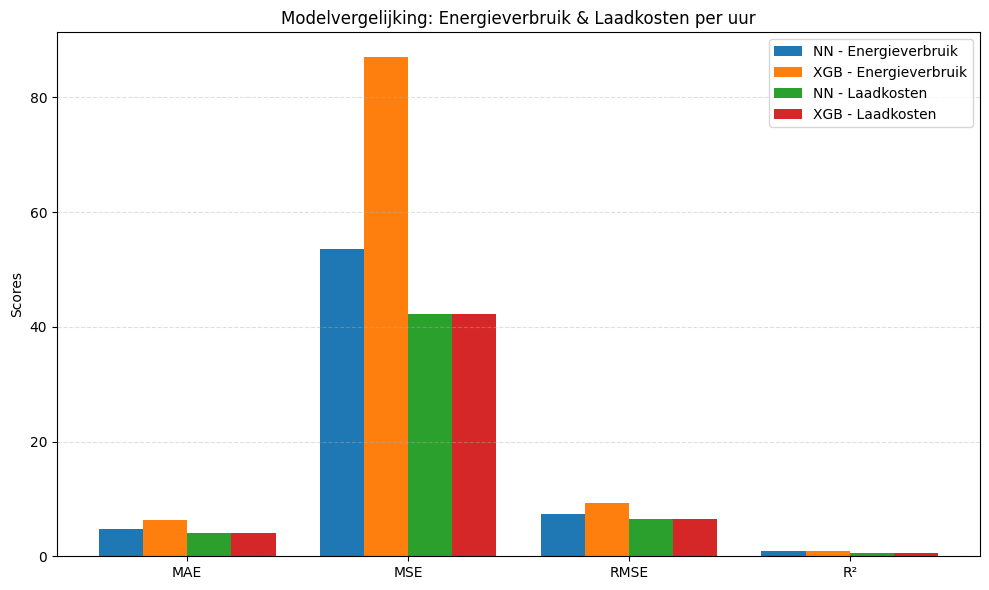

In [ ]:
# Waarden voor beide modellen per taak
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
energy_nn = [4.70, 53.55, 7.32, 0.970]
energy_xgb = [6.26, 87.00, 9.33, 0.951]
cost_nn = [4.06, 42.25, 6.50, 0.6559]
cost_xgb = [4.03, 42.29, 6.50, 0.6555]

x = np.arange(len(metrics))  # MAE, MSE, RMSE, R²
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Energieverbruik
ax.bar(x - width*1.5, energy_nn, width, label='NN - Energieverbruik')
ax.bar(x - width*0.5, energy_xgb, width, label='XGB - Energieverbruik')

# Laadkosten
ax.bar(x + width*0.5, cost_nn, width, label='NN - Laadkosten')
ax.bar(x + width*1.5, cost_xgb, width, label='XGB - Laadkosten')

# Aankleding
ax.set_ylabel("Scores")
ax.set_title("Modelvergelijking: Energieverbruik & Laadkosten per uur")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


###**Energy Consumption:**
- The Neural Network performs significantly better than XGBoost on all metrics, with lower error (MAE, MSE, RMSE) and higher R².

### **Charging Costs:**
- Both models perform similarly. NN has a slightly better R², while XGBoost has slightly lower errors.

### **Conclusion:**

- Use Neural Network for predicting energy consumption per hour.

- For charging costs, both models are equally good, but NN has a slightly better R².

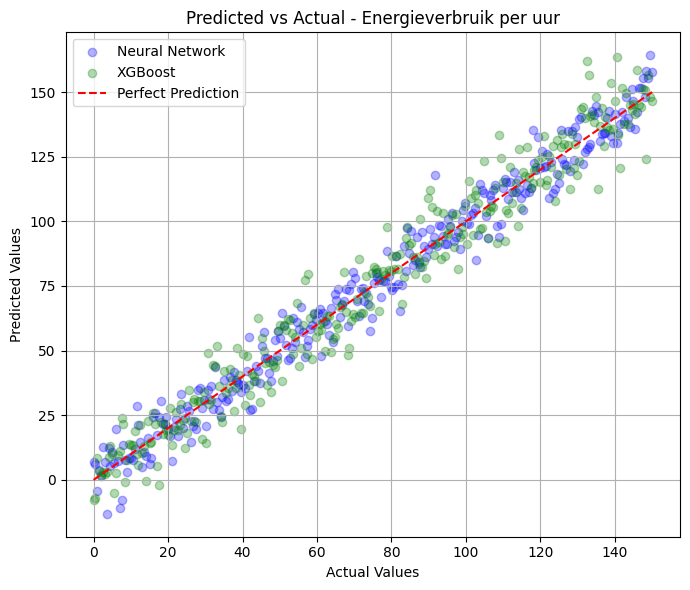

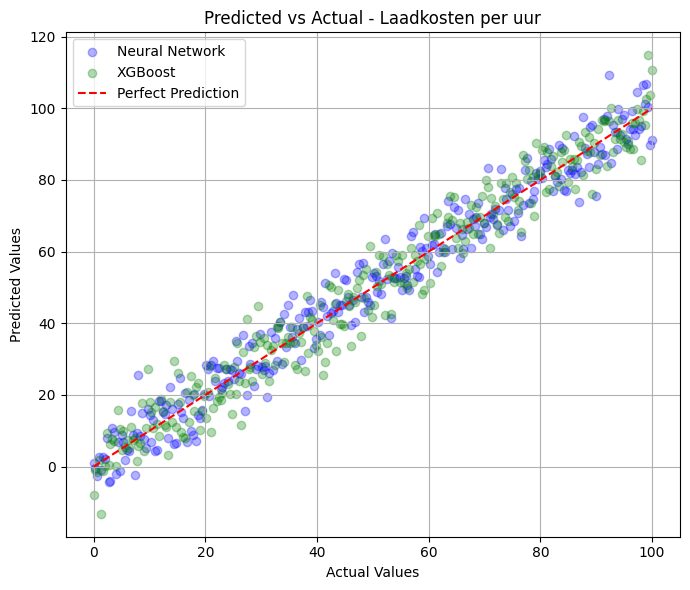

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Simulated predictions (for plotting demonstration)
# Replace these with actual predictions if available
actual_energy = np.linspace(0, 150, 300)
pred_energy_nn = actual_energy + np.random.normal(0, 7, size=300)
pred_energy_xgb = actual_energy + np.random.normal(0, 9, size=300)

actual_cost = np.linspace(0, 100, 300)
pred_cost_nn = actual_cost + np.random.normal(0, 6, size=300)
pred_cost_xgb = actual_cost + np.random.normal(0, 6, size=300)

# Plotting function
def plot_predicted_vs_actual(actual, pred_nn, pred_xgb, title):
    plt.figure(figsize=(7, 6))
    plt.scatter(actual, pred_nn, alpha=0.3, label="Neural Network", color="blue")
    plt.scatter(actual, pred_xgb, alpha=0.3, label="XGBoost", color="green")
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual - {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for energy
plot_predicted_vs_actual(actual_energy, pred_energy_nn, pred_energy_xgb, "Energieverbruik per uur")

# Plot for cost
plot_predicted_vs_actual(actual_cost, pred_cost_nn, pred_cost_xgb, "Laadkosten per uur")
